# School explorations

This notebook explores how testing and contact tracing and other variables and ssumptions can impact spread in schools.

In [64]:
from seirsplus.models import *
from seirsplus.networks import *
from seirsplus.sim_loops import *
from seirsplus.utilities import *
import networkx
import matplotlib.pyplot as pyplot
import itertools
import numpy as np
import pandas as pd

## Schools
We set up the schools and the general class and cohort setting roughly modelled on Vancouver's schools with the BC guidelines.

In [2]:
TOTAL_POP = 5000000

ELEMENTARY_COHORTS = 50
SECONDARY_COHORTS = 10
COHORTS = ELEMENTARY_COHORTS + SECONDARY_COHORTS
STUDENTS_PER_COHORT = [60]*ELEMENTARY_COHORTS + [120]*SECONDARY_COHORTS
CLASSROOMS_PER_COHORT = [3]*ELEMENTARY_COHORTS + [6]*SECONDARY_COHORTS
INTER_CLASSROOM_CONNECTIONS = [6]*ELEMENTARY_COHORTS + [12]*SECONDARY_COHORTS # number of connections between classrooms within cohort
INTER_COHORT_CONNECTIONS = 10              # number of connections between cohorts, (siblings and playdates)
total_classrooms = sum(CLASSROOMS_PER_COHORT)
CLASSROOM_WEIGHTS = (numpy.random.random(total_classrooms)*0.5+0.1).tolist()  # classroom weights, maybe ventilation or adherence to protocol
INTER_CLASSROOM_WEIGHTS = 0.5              # learning group outside classroom interactions transmission weight
INTER_COHORT_WEIGHT = 0.5                  # siblings and playdates interactions transmission weight
DISTANCE_FACT = 0.2                        # 
#PCT_CONTACTS_INTERCOHORT = 0.05           # siblings and playdates

N = sum(STUDENTS_PER_COHORT)
'Total students: %d' % N

'Total students: 4200'

In [3]:
def generate_school_contact_network(num_cohorts=5, 
                                    num_nodes_per_cohort=60, 
                                    num_classrooms_per_cohort=3,
                                    inter_classroom_connections=6, 
                                    inter_cohort_connections = 10,
                                    distance_fact = 0.2,
                                    classroom_weights = 1, 
                                    inter_classroom_weights = 1, 
                                    inter_cohort_weight = 1):

    cohortIndices = {}
    cohortClassroomIndices = {}
    classroomIndices = {}
    G = networkx.Graph()
    numClassrooms = sum(num_classrooms_per_cohort) if isinstance(num_classrooms_per_cohort, list) else num_classrooms_per_cohort * num_cohorts
    classroomWeights = classroom_weights if isinstance(classroom_weights, list) else [classroom_weights] * numClassrooms
    interClassroomWeights = inter_classroom_weights if isinstance(inter_classroom_weights, list) else [inter_classroom_weights] * num_cohorts
    distanceFact = distance_fact if isinstance(distance_fact, list) else [distance_fact] * numClassrooms
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Generate dense classroom networks:
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    for ci in range(num_cohorts):
        numNodes            = num_nodes_per_cohort[ci] if isinstance(num_nodes_per_cohort, list) else num_nodes_per_cohort
        numCl = num_classrooms_per_cohort[ci] if isinstance(num_classrooms_per_cohort, list) else num_classrooms_per_cohort
        meanClassroomSize = numNodes/numCl
        classroomSizes=list(map(lambda i: round(meanClassroomSize+np.random.randint(-meanClassroomSize/5,meanClassroomSize/5)),range(numCl)))
        difference = numNodes - sum(list(classroomSizes))
        index = classroomSizes.index(max(classroomSizes)) if difference > 0 else classroomSizes.index(min(classroomSizes))
        classroomSizes[index]+=difference

        cs = 'c'+str(ci)
        cti = {}
        for ti in classroomSizes:
            i = len(classroomIndices)
            class_weight = classroomWeights[i]
            ts = 't'+str(i)
            tids = list(range(len(G.nodes),len(G.nodes)+ti))
            cti[ts]=tids
            GT = networkx.complete_graph(tids)
            networkx.set_edge_attributes(GT,cs,'cohort')
            networkx.set_edge_attributes(GT,ts,'classroom')

            # non-close contacts get weight down by distance factor
            distance_weight = class_weight * distanceFact[ci]
            networkx.set_edge_attributes(GT,distance_weight,'weight')

            # generate clusters of about 4 as closer contacts
            clusterEdges = {}
            offset = min(tids)
            end_offset=max(tids)-1
            meanClusterSize = 4
            while offset < end_offset:
                step=meanClusterSize+np.random.randint(-2,2)
                if offset+step>ti:
                    step=end_offset-offset
                for i in range(step):
                    for j in range(i+1,step):
                        #GT[offset+i][offset+j]['weight']=class_weight
                        clusterEdges[(offset+i,offset+j)] = {'weight':class_weight}
                offset+=step

            # override weights for cluster contacts
            networkx.set_edge_attributes(GT,clusterEdges)  
            
            G = networkx.compose(G,GT)
            classroomIndices[ts]=tids

        cohortClassroomIndices[cs]=list(cti.keys())
        cohortIndices[cs]=numpy.concatenate(list(cti.values())).ravel().tolist()

    
    # Generate inter-classroom (intra cohort) connections

    for ci in range(len(cohortIndices)):
        cs = list(cohortIndices.keys())[ci]
        numInterClassroomConnections = inter_classroom_connections[ci] if isinstance(inter_classroom_connections, list) else inter_team_connections
        ts = cohortClassroomIndices[cs]
        for i in range(len(ts)):
            for j in range(i+1,len(ts)):
                t1 = numpy.random.choice(classroomIndices[ts[i]],numInterClassroomConnections)
                t2 = numpy.random.choice(classroomIndices[ts[j]],numInterClassroomConnections)
                newEdges = list(map(lambda k: [t1[k],t2[k]],range(numInterClassroomConnections)))
                G.add_edges_from(map(lambda e: e+[{'weight':interClassroomWeights[ci],'cohort':cs}],newEdges))


                
    # Generate inter-cohort connections

    cs = list(cohortIndices.keys())
    for i in range(len(cs)):
        for j in range(i+1,len(cs)):
            c1 = numpy.random.choice(cohortIndices[cs[i]],inter_cohort_connections)
            c2 = numpy.random.choice(cohortIndices[cs[j]],inter_cohort_connections)
            newEdges = list(map(lambda k: [c1[k],c2[k]],range(inter_cohort_connections)))
            G.add_edges_from(map(lambda e: e+[{'weight':inter_cohort_weight}],newEdges))

                
    return G, cohortIndices, cohortClassroomIndices, classroomIndices


In [4]:
schoolNetwork, cohorts_indices, cohort_classrooms, classroom_indices = generate_school_contact_network(
    distance_fact = DISTANCE_FACT,
    classroom_weights = CLASSROOM_WEIGHTS, 
    inter_classroom_weights = INTER_CLASSROOM_WEIGHTS, 
    inter_cohort_weight = INTER_COHORT_WEIGHT,
    num_cohorts=COHORTS,
    num_nodes_per_cohort=STUDENTS_PER_COHORT,
    num_classrooms_per_cohort=CLASSROOMS_PER_COHORT,
    inter_classroom_connections=INTER_CLASSROOM_CONNECTIONS,
    inter_cohort_connections = INTER_COHORT_CONNECTIONS)

schoolNetworkQ = networkx.classes.function.create_empty_copy(schoolNetwork)  # perfect quarantine

In [5]:
#list(schoolNetwork.edges(data=True))[1:10]

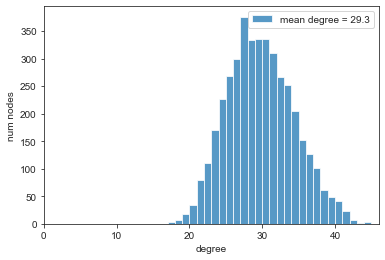

In [6]:
plot_degree_distn(schoolNetwork)

In [7]:
options = {
    'node_color': 'steelblue',
    'node_size': 50,
    'node_shape':'o',
    'line_color': 'brown',
    'linewidths': 1,
    'width': 1,
}
#networkx.draw(schoolNetwork, **options)
#pyplot.show()

### Example elementary cohort network

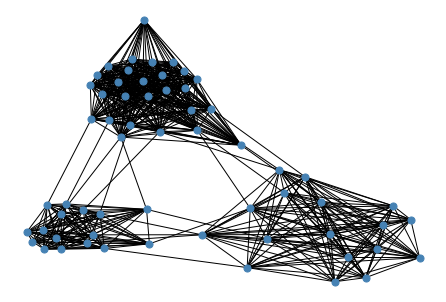

In [8]:
networkx.draw(schoolNetwork.subgraph(cohorts_indices['c0']), **options)
pyplot.show()

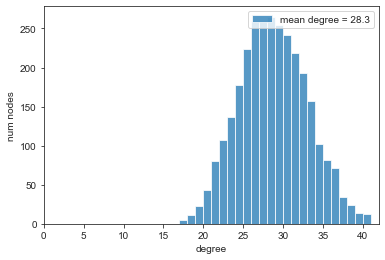

In [9]:
elementary_students = list(itertools.chain(*(map(lambda x: cohorts_indices['c' + str(x)],range(0,ELEMENTARY_COHORTS)))))
plot_degree_distn(schoolNetwork.subgraph(elementary_students))

### Example secondary cohort network

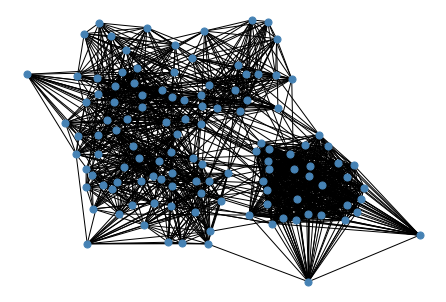

In [10]:
networkx.draw(schoolNetwork.subgraph(cohorts_indices['c'+str(ELEMENTARY_COHORTS)]), **options)
pyplot.show()

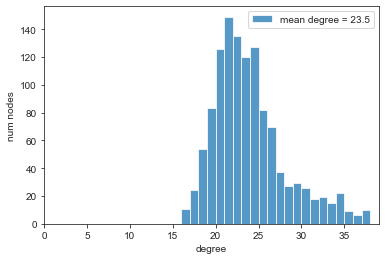

In [11]:
secondary_students = list(itertools.chain(*(map(lambda x: cohorts_indices['c' + str(x)],list(range(ELEMENTARY_COHORTS,SECONDARY_COHORTS+ELEMENTARY_COHORTS))))))
plot_degree_distn(schoolNetwork.subgraph(secondary_students))

# Standard parameters

These are standard parameters copied over from other examples. They set general model parameters like distribtions of R_0 and progression of infections.

Individual R0:  mean = 2.50, std = 0.50, 95% CI = (1.60, 3.58)



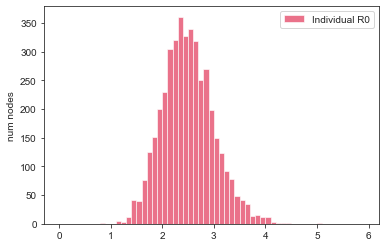

In [12]:
R0_mean     = 2.5
R0_coeffvar = 0.2

R0 = gamma_dist(R0_mean, R0_coeffvar, N)

dist_info(R0, "Individual R0", bin_size=0.1, plot=True, colors='crimson')

latent period:  mean = 2.22, std = 1.11, 95% CI = (0.59, 4.73)

pre-symptomatic period:  mean = 3.04, std = 1.82, 95% CI = (0.61, 7.50)

total incubation period:  mean = 5.26, std = 2.10, 95% CI = (2.08, 10.12)



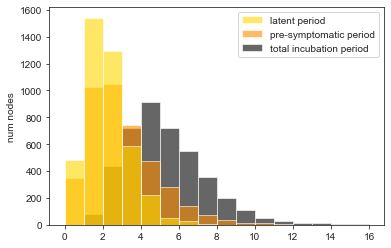

In [13]:
latentPeriod_mean, latentPeriod_coeffvar = 3.0, 0.6
SIGMA   = 1 / gamma_dist(latentPeriod_mean, latentPeriod_coeffvar, N)

presymptomaticPeriod_mean, presymptomaticPeriod_coeffvar = 2.2, 0.5
LAMDA   = 1 / gamma_dist(presymptomaticPeriod_mean, presymptomaticPeriod_coeffvar, N)

dist_info([1/LAMDA, 1/SIGMA, 1/LAMDA+1/SIGMA], ["latent period", "pre-symptomatic period", "total incubation period"], plot=True, colors=['gold', 'darkorange', 'black'], reverse_plot=True)

pre-symptomatic period:  mean = 2.22, std = 1.11, 95% CI = (0.59, 4.73)

(a)symptomatic period:  mean = 4.05, std = 1.63, 95% CI = (1.52, 7.74)

total infectious period:  mean = 6.26, std = 1.96, 95% CI = (3.07, 10.59)



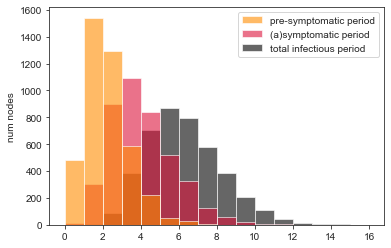

In [14]:
symptomaticPeriod_mean, symptomaticPeriod_coeffvar = 4.0, 0.4
GAMMA   = 1 / gamma_dist(symptomaticPeriod_mean, symptomaticPeriod_coeffvar, N)

infectiousPeriod = 1/LAMDA + 1/GAMMA

dist_info([1/LAMDA, 1/GAMMA, 1/LAMDA+1/GAMMA], ["pre-symptomatic period", "(a)symptomatic period", "total infectious period"], plot=True, colors=['darkorange', 'crimson', 'black'], reverse_plot=True)

onset-to-hospitalization period:  mean = 11.02, std = 4.96, 95% CI = (3.48, 22.65)

hospitalization-to-discharge period:  mean = 10.98, std = 4.98, 95% CI = (3.47, 22.48)

onset-to-discharge period:  mean = 22.00, std = 6.90, 95% CI = (10.29, 37.40)



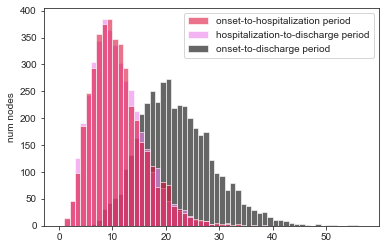

In [15]:
onsetToHospitalizationPeriod_mean, onsetToHospitalizationPeriod_coeffvar = 11.0, 0.45
ETA     = 1 / gamma_dist(onsetToHospitalizationPeriod_mean, onsetToHospitalizationPeriod_coeffvar, N)

hospitalizationToDischargePeriod_mean, hospitalizationToDischargePeriod_coeffvar = 11.0, 0.45
GAMMA_H = 1 / gamma_dist(hospitalizationToDischargePeriod_mean, hospitalizationToDischargePeriod_coeffvar, N)

dist_info([1/ETA, 1/GAMMA_H, 1/ETA+1/GAMMA_H], ["onset-to-hospitalization period", "hospitalization-to-discharge period", "onset-to-discharge period"], plot=True, colors=['crimson', 'violet', 'black'], reverse_plot=True)

onset-to-hospitalization period:  mean = 11.02, std = 4.96, 95% CI = (3.48, 22.65)

hospitalization-to-death period:  mean = 6.95, std = 3.13, 95% CI = (2.18, 14.18)

onset-to-death period:  mean = 17.97, std = 5.88, 95% CI = (8.35, 31.26)



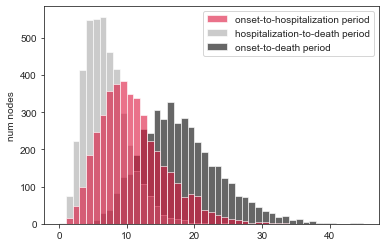

In [16]:
hospitalizationToDeathPeriod_mean, hospitalizationToDeathPeriod_coeffvar = 7.0, 0.45
MU_H    = 1 / gamma_dist(hospitalizationToDeathPeriod_mean, hospitalizationToDeathPeriod_coeffvar, N)

dist_info([1/ETA, 1/MU_H, 1/ETA+1/MU_H], ["onset-to-hospitalization period", "hospitalization-to-death period", "onset-to-death period"], plot=True, colors=['crimson', 'darkgray', 'black'], reverse_plot=True)

In [17]:
# derived progression parameters
BETA = 1/infectiousPeriod * R0
BETA_Q = BETA * (0.3/R0_mean)
BETA_PAIRWISE_MODE  = 'infected'
DELTA_PAIRWISE_MODE = 'infectee' #'mean'

## Testing and quarantine protocol
The testing and quarantine protocol is set up quite aggressively, assuming that quarantine of symptomatic as well as tested positive individuals can be effectively enforced. It's also assuming at symptomatic cases quarantine fast with only few (maybe with light symptoms) offenders.

In [18]:
INTERVENTION_START_PCT_INFECTED = 0 # always test/trace

TESTING_CADENCE                 = 'everyday'    # how often to do tracing testing and random testing
PCT_TESTED_PER_DAY              = 1000/N        # max daily test allotment defined as a percent of population size
TEST_FALSENEG_RATE              = 'temporal'    # test false negative rate, will use FN rate that varies with disease time
MAX_PCT_TESTS_FOR_SYMPTOMATICS  = 1.0           # max percent of daily test allotment to use on self-reporting symptomatics
MAX_PCT_TESTS_FOR_TRACES        = 1.0           # max percent of daily test allotment to use on contact traces
RANDOM_TESTING_DEGREE_BIAS      = 0             # magnitude of degree bias in random selections for testing, none here

PCT_CONTACTS_TO_TRACE           = 0.99          # percentage of primary cases' contacts that are traced
TRACING_LAG                     = 1             # number of cadence testing days between primary tests and tracing tests

ISOLATION_LAG_SYMPTOMATIC       = 1             # number of days between onset of symptoms and self-isolation of symptomatics
ISOLATION_LAG_POSITIVE          = 1             # test turn-around time (TAT): number of days between administration of test and isolation of positive cases
ISOLATION_LAG_CONTACT           = 0             # number of days between a contact being traced and that contact self-isolating



In [19]:
TESTING_COMPLIANCE_RATE_SYMPTOMATIC                  = 0.95
TESTING_COMPLIANCE_RATE_TRACED                       = 1
TESTING_COMPLIANCE_RATE_RANDOM                       = 0             # can add random testing

TRACING_COMPLIANCE_RATE                              = 1

ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_INDIVIDUAL     = 0.95
ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_GROUPMATE      = 1
ISOLATION_COMPLIANCE_RATE_POSITIVE_INDIVIDUAL        = 1
ISOLATION_COMPLIANCE_RATE_POSITIVE_GROUPMATE         = 1
ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACT           = 1
ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACTGROUPMATE  = 1

In [20]:
TESTING_COMPLIANCE_RANDOM                        = (numpy.random.rand(N) < TESTING_COMPLIANCE_RATE_RANDOM)
TESTING_COMPLIANCE_TRACED                        = (numpy.random.rand(N) < TESTING_COMPLIANCE_RATE_TRACED)
TESTING_COMPLIANCE_SYMPTOMATIC                   = (numpy.random.rand(N) < TESTING_COMPLIANCE_RATE_SYMPTOMATIC)

TRACING_COMPLIANCE                               = (numpy.random.rand(N) < TRACING_COMPLIANCE_RATE)

ISOLATION_COMPLIANCE_SYMPTOMATIC_INDIVIDUAL      = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_INDIVIDUAL)
ISOLATION_COMPLIANCE_SYMPTOMATIC_GROUPMATE       = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_SYMPTOMATIC_GROUPMATE)
ISOLATION_COMPLIANCE_POSITIVE_INDIVIDUAL         = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_POSITIVE_INDIVIDUAL)
ISOLATION_COMPLIANCE_POSITIVE_GROUPMATE          = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_POSITIVE_GROUPMATE)
ISOLATION_COMPLIANCE_POSITIVE_CONTACT            = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACT)
ISOLATION_COMPLIANCE_POSITIVE_CONTACTGROUPMATE   = (numpy.random.rand(N) < ISOLATION_COMPLIANCE_RATE_POSITIVE_CONTACTGROUPMATE)

# Key parameters

Some key parameters are the percent of asymptomatic cases to expect, suseptibility of students and number of daily cases in the population at larget that can seed cases in schools.

In [21]:
PCT_ASYMPTOMATIC = 0.75                      # share of cases that are asymptomatic. 
TOTAL_CASES_PER_DAY = 100                   # background cases causing exogenous introductions
ALPHA = 0.75                                   # susceptibility to infection, important assumption
P_GLOBALINTXN = 0.05                        # probability of global interactions (network locality)
#Q_GLOBALINTXN = 0.5


In [22]:
NEW_CASES_PER_POP = TOTAL_CASES_PER_DAY / TOTAL_POP
AVERAGE_INTRODUCTIONS_PER_DAY   = N * NEW_CASES_PER_POP
INIT_EXPOSED = max(1,int(AVERAGE_INTRODUCTIONS_PER_DAY *5))
INIT_EXPOSED

1

In [49]:
num_normal_contacts = 5
DELTA = list(map(lambda x: x[1]/num_normal_contacts,list(schoolNetwork.degree)))
#DELTA

## Model

In [50]:
model = ExtSEIRSNetworkModel(G=schoolNetwork, p=P_GLOBALINTXN,
                             beta=BETA, sigma=SIGMA, lamda=LAMDA, gamma=GAMMA, 
                             gamma_asym=GAMMA, eta=ETA, gamma_H=GAMMA_H, mu_H=MU_H,
                             psi_asym = 0.9, psi_sym = 0.98, psi_pre = 0.9, psi_E = 0.6, psi_S = 0.0,
                             a=PCT_ASYMPTOMATIC, h=0.01, f=0.00001,              
                             alpha=ALPHA, beta_pairwise_mode=BETA_PAIRWISE_MODE, 
                             delta_pairwise_mode=DELTA_PAIRWISE_MODE,
                             delta_Q = 0,
                             delta = DELTA, 
                             G_Q=schoolNetworkQ, isolation_time=14,
                             #transition_mode = 'time_in_state',
                             #q=0, beta_Q=BETA_Q, 
                             #o= 0.2, prevalence_ext =  NEW_CASES_PER_POP * 5,
                             initE=INIT_EXPOSED)

In [51]:
T = 60       # run for 60 days

In [52]:
run_tti_sim(model, T, 
            intervention_start_pct_infected=INTERVENTION_START_PCT_INFECTED, average_introductions_per_day=AVERAGE_INTRODUCTIONS_PER_DAY,
            testing_cadence=TESTING_CADENCE, pct_tested_per_day=PCT_TESTED_PER_DAY, test_falseneg_rate=TEST_FALSENEG_RATE, 
            testing_compliance_symptomatic=TESTING_COMPLIANCE_SYMPTOMATIC, max_pct_tests_for_symptomatics=MAX_PCT_TESTS_FOR_SYMPTOMATICS,
            testing_compliance_traced=TESTING_COMPLIANCE_TRACED, max_pct_tests_for_traces=MAX_PCT_TESTS_FOR_TRACES,
            testing_compliance_random=TESTING_COMPLIANCE_RANDOM, random_testing_degree_bias=RANDOM_TESTING_DEGREE_BIAS,
            tracing_compliance=TRACING_COMPLIANCE, pct_contacts_to_trace=PCT_CONTACTS_TO_TRACE, tracing_lag=TRACING_LAG,
            isolation_compliance_symptomatic_individual=ISOLATION_COMPLIANCE_SYMPTOMATIC_INDIVIDUAL, isolation_compliance_symptomatic_groupmate=ISOLATION_COMPLIANCE_SYMPTOMATIC_GROUPMATE, 
            isolation_compliance_positive_individual=ISOLATION_COMPLIANCE_POSITIVE_INDIVIDUAL, isolation_compliance_positive_groupmate=ISOLATION_COMPLIANCE_POSITIVE_GROUPMATE,
            isolation_compliance_positive_contact=ISOLATION_COMPLIANCE_POSITIVE_CONTACT, isolation_compliance_positive_contactgroupmate=ISOLATION_COMPLIANCE_POSITIVE_CONTACTGROUPMATE,
            isolation_lag_symptomatic=ISOLATION_LAG_SYMPTOMATIC, isolation_lag_positive=ISOLATION_LAG_POSITIVE)

[INTERVENTIONS @ t = 6.45 (1 (0.02%) infected)]
	0	tested due to symptoms  [+ 0 positive (0.00 %) +]
	0	tested as traces        [+ 0 positive (0.00 %) +]
	0	tested randomly         [+ 0 positive (0.00 %) +]
	0	tested TOTAL            [+ 0 positive (0.00 %) +]
	0 will isolate due to symptoms         (0 as groupmates of symptomatic)
	0 will isolate due to positive test    (0 as groupmates of positive)
	0 will isolate due to positive contact (0 as groupmates of contact)
	0 entered isolation
[INTERVENTIONS @ t = 7.41 (3 (0.07%) infected)]
	1	tested due to symptoms  [+ 0 positive (0.00 %) +]
	0	tested as traces        [+ 0 positive (0.00 %) +]
	0	tested randomly         [+ 0 positive (0.00 %) +]
	1	tested TOTAL            [+ 0 positive (0.00 %) +]
	1 will isolate due to symptoms         (0 as groupmates of symptomatic)
	0 will isolate due to positive test    (0 as groupmates of positive)
	0 will isolate due to positive contact (0 as groupmates of contact)
	0 entered isolation
[INTERVENTIONS

[INTERVENTIONS @ t = 26.02 (37 (0.88%) infected)]
	1	tested due to symptoms  [+ 1 positive (100.00 %) +]
	17	tested as traces        [+ 0 positive (0.00 %) +]
	0	tested randomly         [+ 0 positive (0.00 %) +]
	18	tested TOTAL            [+ 1 positive (5.56 %) +]
	1 will isolate due to symptoms         (0 as groupmates of symptomatic)
	1 will isolate due to positive test    (0 as groupmates of positive)
	21 will isolate due to positive contact (0 as groupmates of contact)
	22 entered isolation
[INTERVENTIONS @ t = 27.01 (39 (0.93%) infected)]
	0	tested due to symptoms  [+ 0 positive (0.00 %) +]
	26	tested as traces        [+ 0 positive (0.00 %) +]
	0	tested randomly         [+ 0 positive (0.00 %) +]
	26	tested TOTAL            [+ 0 positive (0.00 %) +]
	1 will isolate due to symptoms         (0 as groupmates of symptomatic)
	0 will isolate due to positive test    (0 as groupmates of positive)
	27 will isolate due to positive contact (0 as groupmates of contact)
	29 entered isolation


[NEW EXPOSURE @ t = 43.00 (1 exposed)]
[INTERVENTIONS @ t = 43.00 (298 (7.10%) infected)]
	4	tested due to symptoms  [+ 4 positive (100.00 %) +]
	687	tested as traces        [+ 12 positive (1.75 %) +]
	0	tested randomly         [+ 0 positive (0.00 %) +]
	691	tested TOTAL            [+ 16 positive (2.32 %) +]
	8 will isolate due to symptoms         (0 as groupmates of symptomatic)
	16 will isolate due to positive test    (0 as groupmates of positive)
	1792 will isolate due to positive contact (0 as groupmates of contact)
	1860 entered isolation
[INTERVENTIONS @ t = 44.02 (265 (6.31%) infected)]
	12	tested due to symptoms  [+ 10 positive (83.33 %) +]
	383	tested as traces        [+ 8 positive (2.09 %) +]
	0	tested randomly         [+ 0 positive (0.00 %) +]
	395	tested TOTAL            [+ 18 positive (4.56 %) +]
	3 will isolate due to symptoms         (0 as groupmates of symptomatic)
	18 will isolate due to positive test    (0 as groupmates of positive)
	456 will isolate due to positive c

(6.450292454603349, 60.002942916672254)

In [53]:
results_summary(model)

total percent infected: 17.24%
total percent fatality: 0.00%
peak  pct hospitalized: 0.05%


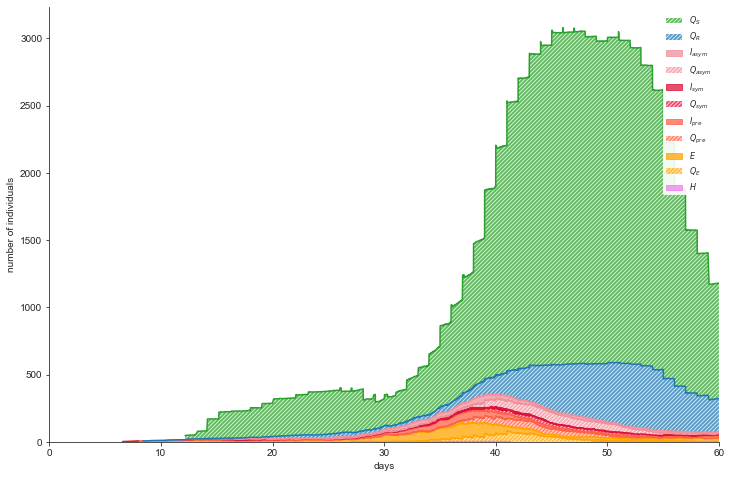

In [54]:
fig, ax = model.figure_infections(combine_Q_infected=False, plot_Q_R='stacked', plot_Q_S='stacked', plot_percentages=False)

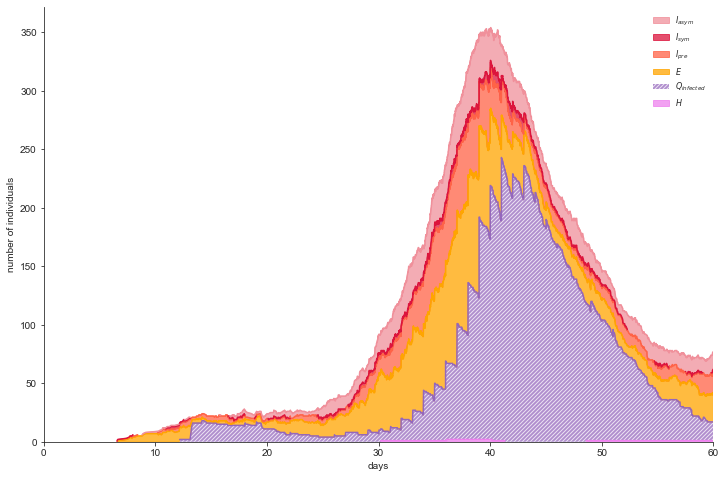

In [55]:
fig, ax = model.figure_infections(combine_Q_infected=True, plot_S=False,plot_R=False, plot_percentages=False)

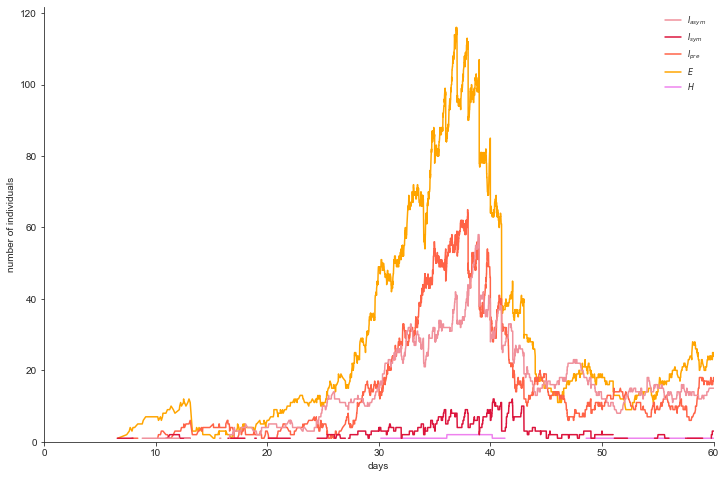

In [58]:
fig, ax = model.figure_basic(plot_S=False, plot_E='line', plot_R=False, plot_F='line',
                        plot_Q_E=False, plot_percentages=False)

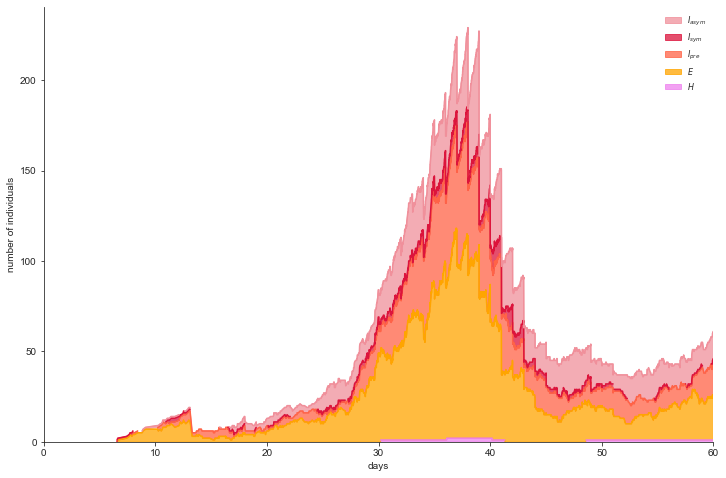

In [61]:
fig, ax = model.figure_infections(plot_S=False, plot_R=False, plot_Q_E=False, plot_percentages=False)

In [67]:
model.t

60.002942916672254

In [76]:
data ={'time':model.tseries, 
       'S':model.numS,
       'R':model.numR, 
       'E':model.numE, 
       'I_pre':model.numI_pre,
       'I_sym':model.numI_sym,
       'I_asym':model.numI_asym,
       'H':model.numH,
       'F':model.numF,
       'Q_S':model.numQ_S,
       'Q_E':model.numQ_E, 
       'Q_R':model.numQ_R, 
       'Q_I_pre':model.numQ_pre,
       'Q_I_sym':model.numQ_sym,
       'Q_I_asym':model.numQ_asym,

      }

df = pd.DataFrame(data, columns= list(data.keys()))
df.to_csv (r'./export_dataframe.csv', index = False, header=True)
